<a href="https://colab.research.google.com/github/lucasresck/deep-reinforcement-learning/blob/master/notebooks/breakout_optimization_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breakout optimization analysis

## Original code

In [1]:
# Inspired by 'Playing Atari with Deep Reinforcement Learning' (https://arxiv.org/abs/1312.5602)

from collections import deque
from gym import wrappers
from keras.layers import Dense
from keras.models import load_model, Sequential
from keras.optimizers import Adam
import argparse
import gym
import numpy as np
import os
import pickle
import random
import tensorflow as tf
import time


class NeuralNetwork():
    def __init__(self, input_shape, action_size, learning_rate=0.001):
        self.input_shape = input_shape
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.model = self.model_of_network()

    def model_of_network(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(
                filters=16,
                kernel_size=8,
                input_shape=self.input_shape
            ),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(
                filters=16,
                kernel_size=4
            ),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(
                units=128,
                activation='relu'
            ),
            tf.keras.layers.Dense(
                units=self.action_size,
                activation='linear'
            )
        ])
        print(model.summary())
        model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop(learning_rate=self.learning_rate))
        return model


class DeepQAgent():
    def __init__(
        self,
        record,
        env_name='Breakout-v0',
        gamma=0.999,
        max_frames=1000,
        max_iterations=1000000,
        epsilon_decay_until=100000,
        epsilon_min=0.1,
        replay_memory_capacity=100000,
        minibatch_size=32,
        nn_input_shape=(80, 80, 4),
        n_history = 4
    ):
        self.env = gym.make(env_name)
        if record:
            self.env = wrappers.Monitor(self.env, os.path.join(os.getcwd(), 'videos', str(time.time())))
        self.set_seeds(int(time.time()))
        self.gamma = gamma
        self.max_frames = max_frames
        self.max_iterations = max_iterations
        self.obs_shape = self.env.observation_space.shape
        self.action_size = self.env.env.action_space.n
        self.epsilon = 1.0
        self.epsilon_decay_until = epsilon_decay_until
        self.epsilon_min = epsilon_min
        self.replay_memory_capacity = replay_memory_capacity
        self.minibatch_size = minibatch_size
        self.nn_input_shape = nn_input_shape
        self.neural_network = NeuralNetwork(self.nn_input_shape, self.action_size)
        self.n_history = n_history
        self.history = deque(maxlen=self.n_history)

    def set_seeds(self, seed):
        """Set random seeds using current time."""
        self.env.seed(seed)
        np.random.seed(seed)
        random.seed(seed)

    def train(self):
        """Train deep Q-learning agent."""
        self.start_time = time.time()
        self.deep_q_learning()

    def deep_q_learning(self):
        """
        Deep Q-learning algorithm.
        It learns the Q function without knowing the transition probabilities, through deep neural networks.
        """
        self.replay_memory = deque(maxlen=self.replay_memory_capacity)
        self.target_network = NeuralNetwork(self.nn_input_shape, self.action_size)
        self.target_network.model.set_weights(self.neural_network.model.get_weights())

        episode = 0
        self.i_frames = 0
        while self.i_frames < self.max_frames:
            if self.train_episode(episode):
                break
            # if (episode + 1) % 50 == 0:
            #     self.sample(1)
            episode += 1

        self.env.close()

    def train_episode(self, episode):
        """Train one episode of deep Q-learning."""
        self.history = deque(maxlen=self.n_history)
        obs = self.env.reset()
        state = self.preprocess(obs)
        self.i_frames += 1
        total_reward = 0
        for i in range(self.max_iterations):
            action = self.take_action(state)
            obs, reward, done, _ = self.env.step(action)
            state_ = self.preprocess(obs)
            self.replay_memory.append([state, action, reward, state_, done])
            self.train_from_replay()
            state = state_
            total_reward += reward
            self.i_frames += 1
            # self.env.render()
            if self.i_frames >= self.max_frames:  # Max frames
                return True
            if done:
                break
        self.report(i, episode, total_reward)
        self.sync_networks()
        return False

    def preprocess(self, obs):
        """Preprocess observation."""
        gray = self.gray(obs)
        img = self.cut(gray)
        img = self.resize(img)
        state = self.create_state(img)
        return state

    def gray(self, obs):
        return np.mean(obs, axis=2)

    def cut(self, gray):
        img = gray[32:, :]
        x, y = img.shape
        img = img[:-np.abs(x-y), :]
        return img
    
    def resize(self, img):
        new_img = np.zeros((int(np.ceil(img.shape[0]/2)), int(np.ceil(img.shape[1]/2))))
        for i in range(int(np.ceil(img.shape[0]/2))):
            for j in range(int(np.ceil(img.shape[1]/2))):
                new_img[i, j] = np.max(img[2*i:2*i+2, 2*j:2*j+2])
        img = new_img
        img = img.reshape(img.shape[0], img.shape[1], 1)
        return img

    def create_state(self, img):
        self.history.append(img)
        state = np.concatenate(tuple(self.history), axis=2)
        for _ in range(self.n_history - state.shape[2]):
            state = np.concatenate((state, self.history[-1]), axis=2)  
        return state

    def take_action(self, state):
        """
        Take action based in epsilon-greedy algorithm.
        With small probabily, take a random action;
        otherwise, take the action from the neural network.
        """
        self.update_epsilon()
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.action_size)
        else:
            output = self.compute_values(state)
            action = np.argmax(output)
        return action

    def update_epsilon(self):
        """Update epsilon for epsilon-greedy algorithm."""
        epsilon = 1 + (self.i_frames * self.epsilon_min - self.i_frames) / self.epsilon_decay_until
        self.epsilon = np.max([self.epsilon_min, epsilon])

    def compute_values(self, state):
        """Compute values of a state."""
        logits = self.neural_network.model.predict(state[None, :])
        return logits[0, :]

    def train_from_replay(self):
        """Train neural network from samples of replay memory."""
        if len(self.replay_memory) < self.minibatch_size:
            # If there isn't enough samples
            return
        minibatch = random.sample(self.replay_memory, self.minibatch_size)
        states, states_ = self.extract_states(minibatch)
        targets = self.calculate_targets(minibatch, states, states_)
        self.fit(states, targets)

    def extract_states(self, minibatch):
        states = []
        states_ = []
        for sample in minibatch:
            state, action, reward, state_, done = sample
            states.append(state)
            states_.append(state_)
        states = np.array(states)
        states_ = np.array(states_)
        return states, states_

    def calculate_targets(self, minibatch, states, states_):
        targets, targets_ = self.target_predict(states, states_)
        for i, sample in enumerate(minibatch):
            state, action, reward, state_, done = sample
            if done:
                targets[i][action] = reward
            else:
                targets[i][action] = reward + self.gamma * np.max(targets_[i])
        return targets

    def target_predict(self, states, states_):
        targets = self.neural_network.model.predict(states)
        targets_ = self.target_network.model.predict(states_)
        return targets, targets_

    def fit(self, states, targets):
        self.neural_network.model.fit(
            x=states,
            y=targets,
            verbose=0
        )

    def report(self, i, episode, total_reward):
        """Show status on console."""
        time_now = (time.time() - self.start_time) / 60
        print('Ep. {}. Reward = {}, epsilon = {}, time = {:.2f}min'.format(episode, total_reward, self.epsilon, time_now), end='\n\n')

    def sync_networks(self):
        """Sync original and target neural networks."""
        self.target_network.model.set_weights(self.neural_network.model.get_weights())

    def sample_experience(self):
        """Sample experience from replay memory."""
        return self.replay_memory[np.random.choice(len(self.replay_memory))]

    def save_network(self, network_path):
        """Save the network in order to run it faster."""
        os.makedirs(os.path.dirname(network_path), exist_ok=True)
        self.neural_network.model.save(network_path)
        print('Neural network saved.', end='\n\n')

    def load_network(self, network_path):
        """Load the network in order to run it faster."""
        self.neural_network.model = load_model(network_path)
        print('Neural network loaded.', end='\n\n')

    def sample(self, n):
        """Sample the network."""
        print('Sampling network:')
        for _ in range(n):
            self.run_episode(render=True)
        print()

    def run_episode(self, render=False):
        """Run one episode for our network."""
        obs = self.env.reset()
        total_reward = 0
        for _ in range(self.max_iterations):
            state = self.normalize_obs(obs)
            action = self.which_action(state)
            obs, reward, done, _ = self.env.step(action)
            total_reward += reward
            if render:
                self.env.render()
            if done:
                break
        self.env.close()
        print('Reward: ', total_reward)

    def which_action(self, state):
        """Select which is the best action based on the network."""
        return np.argmax(self.compute_values(state))


def main():    
    # parser = argparse.ArgumentParser()
    # parser.add_argument('--run', action='store_true')
    # parser.add_argument('--record', action='store_true')
    # args = parser.parse_args()
    # args.record = False
    agent = DeepQAgent(False)#args.record)
    # if args.run:
    #     agent.load_network('data/deep_q_learning.h5')
    #     agent.sample(5)
    # else:
    agent.train()
    agent.save_network('data/deep_q_learning.h5')


Using TensorFlow backend.


## Stats generation

In [2]:
import cProfile
cProfile.run('main()', 'breakout-colab-gpu-stats')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 16)        4112      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 16)        4112      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               524416    
_________________________________________

## Stats visualization

In [3]:
import pstats
p = pstats.Stats('breakout-colab-gpu-stats')
p.strip_dirs().sort_stats('cumulative').print_stats('ipython', 15)

Sun Mar 22 00:29:50 2020    breakout-colab-gpu-stats

         62037922 function calls (61857579 primitive calls) in 63.844 seconds

   Ordered by: cumulative time
   List reduced from 2069 to 24 due to restriction <'ipython'>
   List reduced from 24 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   63.843   63.843 <ipython-input-1-ec5ea6e0964c>:294(main)
        1    0.000    0.000   63.168   63.168 <ipython-input-1-ec5ea6e0964c>:92(train)
        1    0.000    0.000   63.168   63.168 <ipython-input-1-ec5ea6e0964c>:97(deep_q_learning)
        4    0.052    0.013   62.288   15.572 <ipython-input-1-ec5ea6e0964c>:117(train_episode)
     1000    0.005    0.000   41.041    0.041 <ipython-input-1-ec5ea6e0964c>:142(preprocess)
     1000    7.254    0.007   40.239    0.040 <ipython-input-1-ec5ea6e0964c>:159(resize)
      996    0.009    0.000   20.452    0.021 <ipython-input-1-ec5ea6e0964c>:199(train_from_repla

We have a problem with preprocess function, in special the resize function.

## Visualize states

Let's see what our network is seeing.

### The treated images

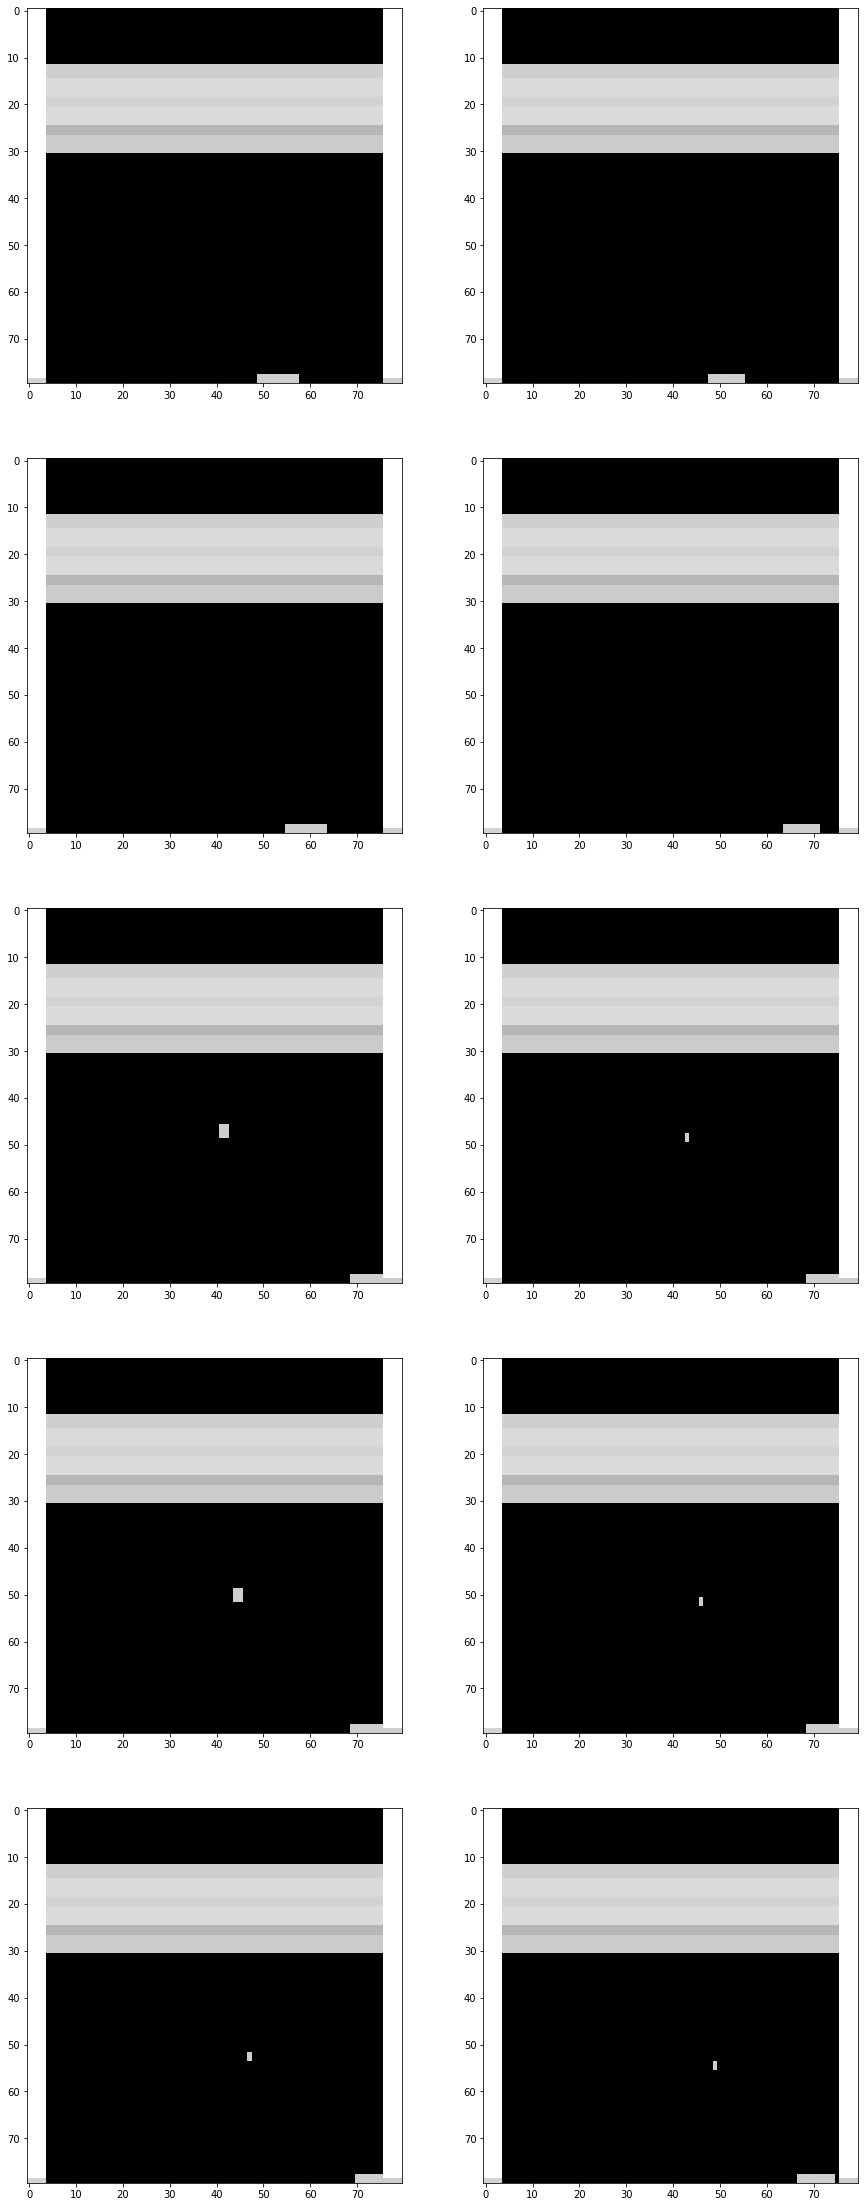

In [4]:
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import gym

n_history = 4
history = deque(maxlen=n_history)

def preprocess(obs):
    """Preprocess observation."""
    gray = gray_f(obs)
    img = cut_f(gray)
    img = resize_f(img)
    state = create_state(img)
    return state, img

def gray_f(obs):
    return np.mean(obs, axis=2)

def cut_f(gray):
    img = gray[32:, :]
    x, y = img.shape
    img = img[:-np.abs(x-y), :]
    return img

def resize_f(img):
    new_img = np.zeros((int(np.ceil(img.shape[0]/2)), int(np.ceil(img.shape[1]/2))))
    for i in range(int(np.ceil(img.shape[0]/2))):
        for j in range(int(np.ceil(img.shape[1]/2))):
            new_img[i, j] = np.max(img[2*i:2*i+2, 2*j:2*j+2])
    img = new_img
    img = img.reshape(img.shape[0], img.shape[1], 1)
    return img

def create_state(img):
    history.append(img)
    state = np.concatenate(tuple(history), axis=2)
    for _ in range(n_history - state.shape[2]):
        state = np.concatenate((state, history[-1]), axis=2)  
    return state

env = gym.make('Breakout-v0')
obs = env.reset()
fig, ax = plt.subplots(5, 2, figsize=(15, 40))
for i in range(10):
    obs, r, done, _ =  env.step(env.action_space.sample())
    state, img = preprocess(obs)
    ax.reshape(10)[i].imshow(img.reshape(80, 80), cmap='gray')
plt.show()

### What the network sees

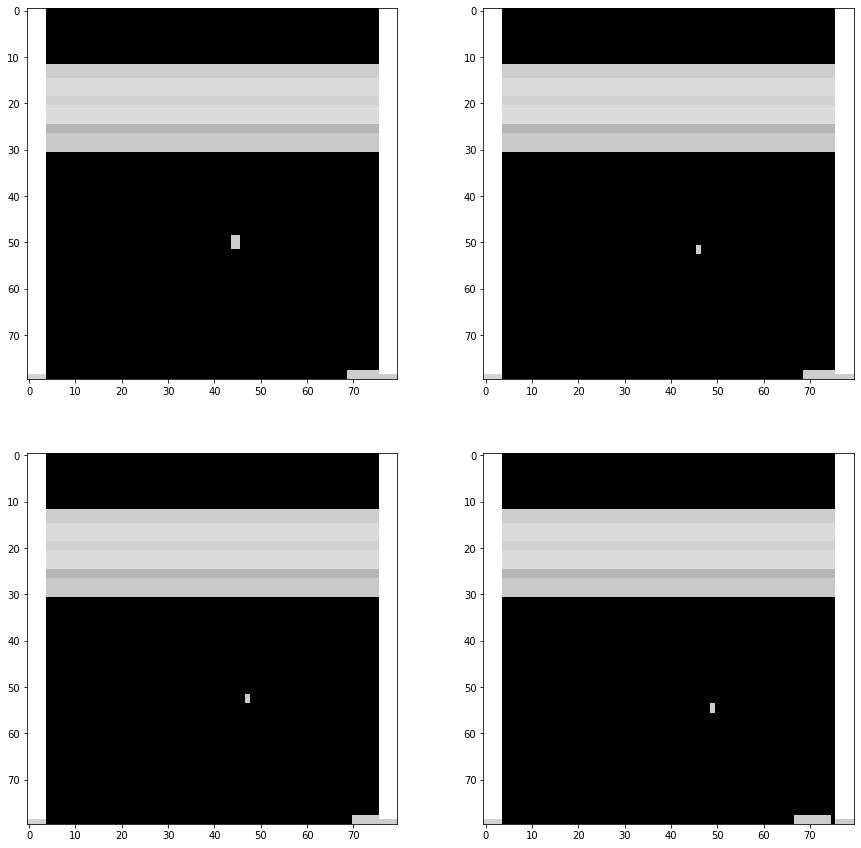

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
for i in range(4):
    img = state[:, :, i].astype(int)
    ax.reshape(4)[i].imshow(img.reshape(80, 80), cmap='gray')
plt.show()

### An approx to what it sees

(80, 80, 3) 142 0


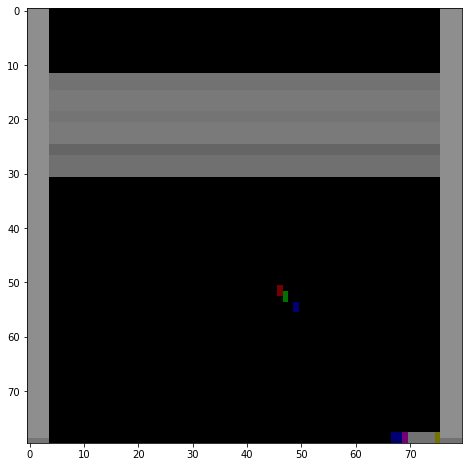

In [6]:
img = state[:, :, 1:].astype(int)
print(img.shape, np.max(img), np.min(img))
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img)
plt.show()

## A try to optimize

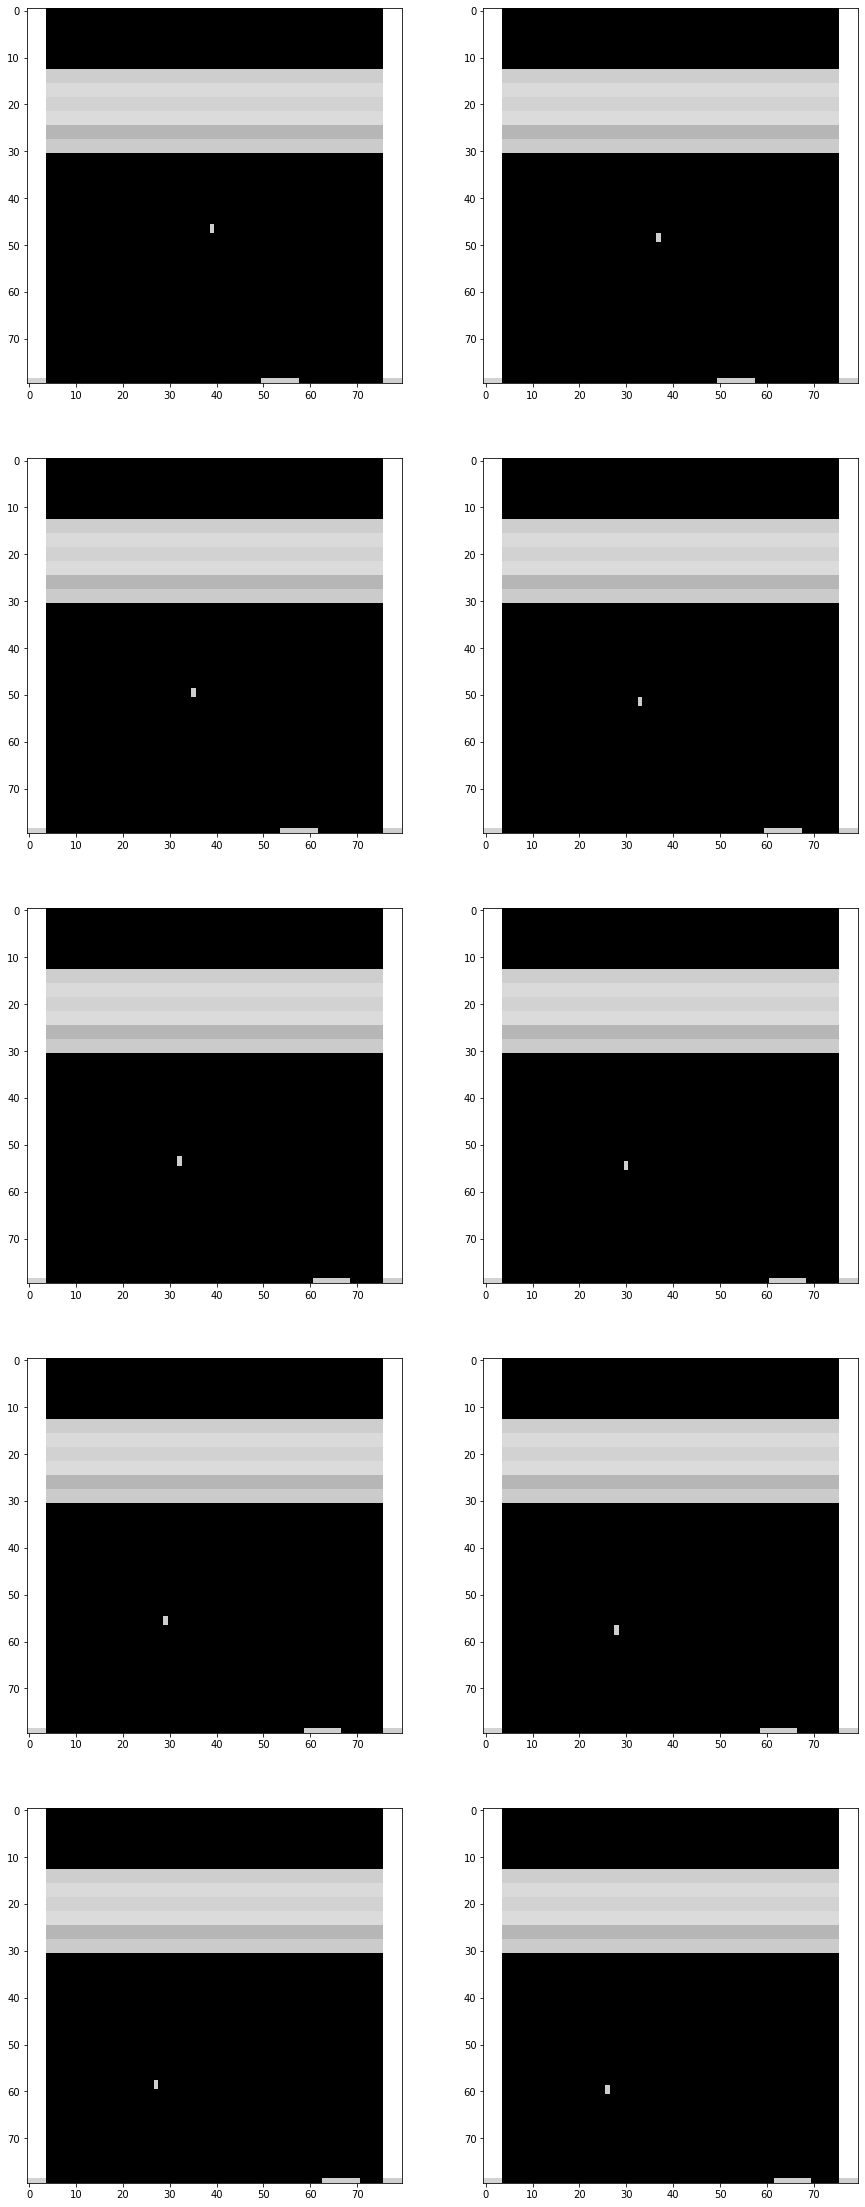

In [7]:
history = deque(maxlen=n_history)

def resize_f(img):
    img = img[list(range(0, img.shape[0], 2)), :][:, list(range(0, img.shape[1], 2))]
    return img.reshape(img.shape[0], img.shape[1], 1)

env = gym.make('Breakout-v0')
obs = env.reset()
fig, ax = plt.subplots(5, 2, figsize=(15, 40))
for i in range(10):
    obs, r, done, _ =  env.step(env.action_space.sample())
    state, img = preprocess(obs)
    ax.reshape(10)[i].imshow(img.reshape(80, 80), cmap='gray')
plt.show()

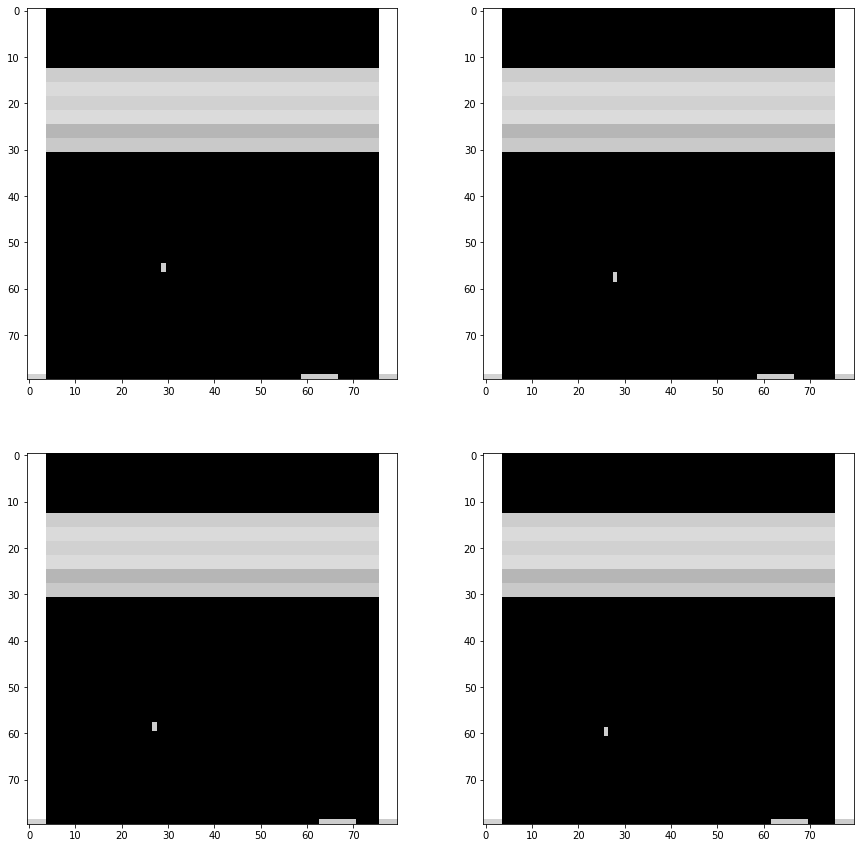

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
for i in range(4):
    img = state[:, :, i].astype(int)
    ax.reshape(4)[i].imshow(img.reshape(80, 80), cmap='gray')
plt.show()

(80, 80, 3) 142 0


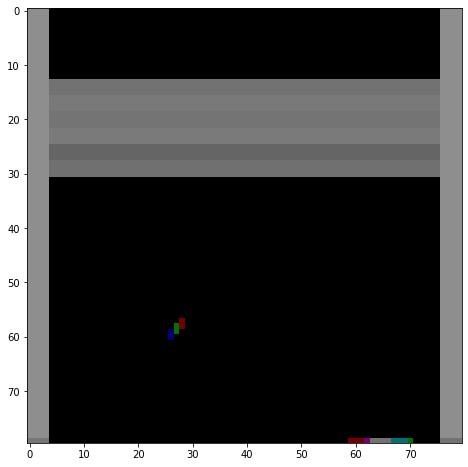

In [9]:
img = state[:, :, 1:].astype(int)
print(img.shape, np.max(img), np.min(img))
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img)
plt.show()

Good result.

## New stats generation

### Code

In [0]:
# Inspired by 'Playing Atari with Deep Reinforcement Learning' (https://arxiv.org/abs/1312.5602)

from collections import deque
from gym import wrappers
from keras.layers import Dense
from keras.models import load_model, Sequential
from keras.optimizers import Adam
import argparse
import gym
import numpy as np
import os
import pickle
import random
import tensorflow as tf
import time


class NeuralNetwork():
    def __init__(self, input_shape, action_size, learning_rate=0.001):
        self.input_shape = input_shape
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.model = self.model_of_network()

    def model_of_network(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(
                filters=16,
                kernel_size=8,
                input_shape=self.input_shape
            ),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(
                filters=16,
                kernel_size=4
            ),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(
                units=128,
                activation='relu'
            ),
            tf.keras.layers.Dense(
                units=self.action_size,
                activation='linear'
            )
        ])
        print(model.summary())
        model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop(learning_rate=self.learning_rate))
        return model


class DeepQAgent():
    def __init__(
        self,
        record,
        env_name='Breakout-v0',
        gamma=0.999,
        max_frames=1000,
        max_iterations=1000000,
        epsilon_decay_until=100000,
        epsilon_min=0.1,
        replay_memory_capacity=100000,
        minibatch_size=32,
        nn_input_shape=(80, 80, 4),
        n_history = 4
    ):
        self.env = gym.make(env_name)
        if record:
            self.env = wrappers.Monitor(self.env, os.path.join(os.getcwd(), 'videos', str(time.time())))
        self.set_seeds(int(time.time()))
        self.gamma = gamma
        self.max_frames = max_frames
        self.max_iterations = max_iterations
        self.obs_shape = self.env.observation_space.shape
        self.action_size = self.env.env.action_space.n
        self.epsilon = 1.0
        self.epsilon_decay_until = epsilon_decay_until
        self.epsilon_min = epsilon_min
        self.replay_memory_capacity = replay_memory_capacity
        self.minibatch_size = minibatch_size
        self.nn_input_shape = nn_input_shape
        self.neural_network = NeuralNetwork(self.nn_input_shape, self.action_size)
        self.n_history = n_history
        self.history = deque(maxlen=self.n_history)

    def set_seeds(self, seed):
        """Set random seeds using current time."""
        self.env.seed(seed)
        np.random.seed(seed)
        random.seed(seed)

    def train(self):
        """Train deep Q-learning agent."""
        self.start_time = time.time()
        self.deep_q_learning()

    def deep_q_learning(self):
        """
        Deep Q-learning algorithm.
        It learns the Q function without knowing the transition probabilities, through deep neural networks.
        """
        self.replay_memory = deque(maxlen=self.replay_memory_capacity)
        self.target_network = NeuralNetwork(self.nn_input_shape, self.action_size)
        self.target_network.model.set_weights(self.neural_network.model.get_weights())

        episode = 0
        self.i_frames = 0
        while self.i_frames < self.max_frames:
            if self.train_episode(episode):
                break
            # if (episode + 1) % 50 == 0:
            #     self.sample(1)
            episode += 1

        self.env.close()

    def train_episode(self, episode):
        """Train one episode of deep Q-learning."""
        self.history = deque(maxlen=self.n_history)
        obs = self.env.reset()
        state = self.preprocess(obs)
        self.i_frames += 1
        total_reward = 0
        for i in range(self.max_iterations):
            action = self.take_action(state)
            obs, reward, done, _ = self.env.step(action)
            state_ = self.preprocess(obs)
            self.replay_memory.append([state, action, reward, state_, done])
            self.train_from_replay()
            state = state_
            total_reward += reward
            self.i_frames += 1
            # self.env.render()
            if self.i_frames >= self.max_frames:  # Max frames
                return True
            if done:
                break
        self.report(i, episode, total_reward)
        self.sync_networks()
        return False

    def preprocess(self, obs):
        """Preprocess observation."""
        gray = self.gray(obs)
        img = self.cut(gray)
        img = self.resize(img)
        state = self.create_state(img)
        return state

    def gray(self, obs):
        return np.mean(obs, axis=2)

    def cut(self, gray):
        img = gray[32:, :]
        x, y = img.shape
        img = img[:-np.abs(x-y), :]
        return img

    def resize(self, img):
        img = img[list(range(0, img.shape[0], 2)), :][:, list(range(0, img.shape[1], 2))]
        return img.reshape(img.shape[0], img.shape[1], 1)

    def create_state(self, img):
        self.history.append(img)
        state = np.concatenate(tuple(self.history), axis=2)
        for _ in range(self.n_history - state.shape[2]):
            state = np.concatenate((state, self.history[-1]), axis=2)  
        return state

    def take_action(self, state):
        """
        Take action based in epsilon-greedy algorithm.
        With small probabily, take a random action;
        otherwise, take the action from the neural network.
        """
        self.update_epsilon()
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.action_size)
        else:
            output = self.compute_values(state)
            action = np.argmax(output)
        return action

    def update_epsilon(self):
        """Update epsilon for epsilon-greedy algorithm."""
        epsilon = 1 + (self.i_frames * self.epsilon_min - self.i_frames) / self.epsilon_decay_until
        self.epsilon = np.max([self.epsilon_min, epsilon])

    def compute_values(self, state):
        """Compute values of a state."""
        logits = self.neural_network.model.predict(state[None, :])
        return logits[0, :]

    def train_from_replay(self):
        """Train neural network from samples of replay memory."""
        if len(self.replay_memory) < self.minibatch_size:
            # If there isn't enough samples
            return
        minibatch = random.sample(self.replay_memory, self.minibatch_size)
        states, states_ = self.extract_states(minibatch)
        targets = self.calculate_targets(minibatch, states, states_)
        self.fit(states, targets)

    def extract_states(self, minibatch):
        states = []
        states_ = []
        for sample in minibatch:
            state, action, reward, state_, done = sample
            states.append(state)
            states_.append(state_)
        states = np.array(states)
        states_ = np.array(states_)
        return states, states_

    def calculate_targets(self, minibatch, states, states_):
        targets, targets_ = self.target_predict(states, states_)
        for i, sample in enumerate(minibatch):
            state, action, reward, state_, done = sample
            if done:
                targets[i][action] = reward
            else:
                targets[i][action] = reward + self.gamma * np.max(targets_[i])
        return targets

    def target_predict(self, states, states_):
        targets = self.neural_network.model.predict(states)
        targets_ = self.target_network.model.predict(states_)
        return targets, targets_

    def fit(self, states, targets):
        self.neural_network.model.fit(
            x=states,
            y=targets,
            verbose=0
        )

    def report(self, i, episode, total_reward):
        """Show status on console."""
        time_now = (time.time() - self.start_time) / 60
        print('Ep. {}. Reward = {}, epsilon = {}, time = {:.2f}min'.format(episode, total_reward, self.epsilon, time_now), end='\n\n')

    def sync_networks(self):
        """Sync original and target neural networks."""
        self.target_network.model.set_weights(self.neural_network.model.get_weights())

    def sample_experience(self):
        """Sample experience from replay memory."""
        return self.replay_memory[np.random.choice(len(self.replay_memory))]

    def save_network(self, network_path):
        """Save the network in order to run it faster."""
        os.makedirs(os.path.dirname(network_path), exist_ok=True)
        self.neural_network.model.save(network_path)
        print('Neural network saved.', end='\n\n')

    def load_network(self, network_path):
        """Load the network in order to run it faster."""
        self.neural_network.model = load_model(network_path)
        print('Neural network loaded.', end='\n\n')

    def sample(self, n):
        """Sample the network."""
        print('Sampling network:')
        for _ in range(n):
            self.run_episode(render=True)
        print()

    def run_episode(self, render=False):
        """Run one episode for our network."""
        obs = self.env.reset()
        total_reward = 0
        for _ in range(self.max_iterations):
            state = self.normalize_obs(obs)
            action = self.which_action(state)
            obs, reward, done, _ = self.env.step(action)
            total_reward += reward
            if render:
                self.env.render()
            if done:
                break
        self.env.close()
        print('Reward: ', total_reward)

    def which_action(self, state):
        """Select which is the best action based on the network."""
        return np.argmax(self.compute_values(state))


def main():    
    # parser = argparse.ArgumentParser()
    # parser.add_argument('--run', action='store_true')
    # parser.add_argument('--record', action='store_true')
    # args = parser.parse_args()
    # args.record = False
    agent = DeepQAgent(False)#args.record)
    # if args.run:
    #     agent.load_network('data/deep_q_learning.h5')
    #     agent.sample(5)
    # else:
    agent.train()
    agent.save_network('data/deep_q_learning.h5')


### Stats generation

In [11]:
cProfile.run('main()', 'breakout-colab-gpu-stats-1')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 73, 73, 16)        4112      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 33, 33, 16)        4112      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               524416    
_________________________________________________________________
dense_5 (Dense)              (None, 4)                

## New stats visualization

In [12]:
p = pstats.Stats('breakout-colab-gpu-stats-1')
p.strip_dirs().sort_stats('cumulative').print_stats('ipython', 20);

Sun Mar 22 00:30:21 2020    breakout-colab-gpu-stats-1

         11011203 function calls (10842481 primitive calls) in 25.653 seconds

   Ordered by: cumulative time
   List reduced from 1785 to 24 due to restriction <'ipython'>
   List reduced from 24 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   25.647   25.647 <ipython-input-10-baf12de83ee2>:289(main)
        1    0.000    0.000   25.028   25.028 <ipython-input-10-baf12de83ee2>:92(train)
        1    0.000    0.000   25.028   25.028 <ipython-input-10-baf12de83ee2>:97(deep_q_learning)
        4    0.119    0.030   24.768    6.192 <ipython-input-10-baf12de83ee2>:117(train_episode)
      996    0.009    0.000   23.095    0.023 <ipython-input-10-baf12de83ee2>:194(train_from_replay)
      965    0.135    0.000    8.919    0.009 <ipython-input-10-baf12de83ee2>:215(calculate_targets)
      965    0.005    0.000    8.589    0.009 <ipython-input-10-baf12de

Nice result.